In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import strid
import matplotlib.pyplot as plt
import scipy.signal

## Defining the system and the random stochastic load

1.098247505930167
3.162277660168379
4.844890458342542
5.943137964272709


Text(0.5, 0, 'Frequency (Hz)')

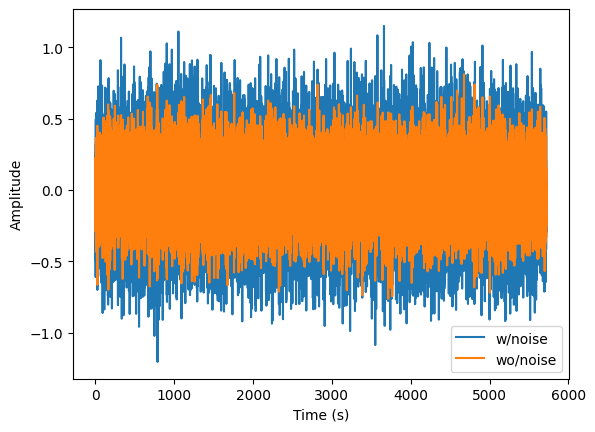

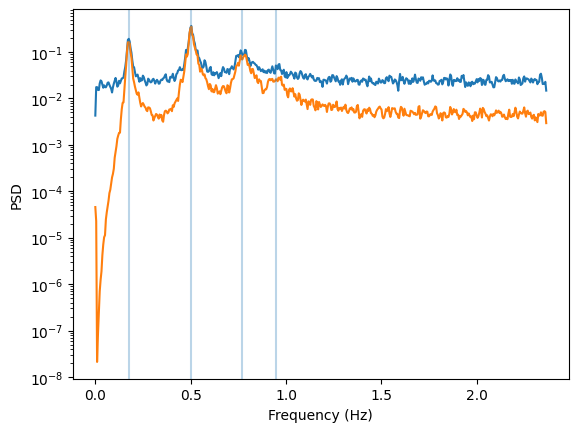

In [5]:
# help(strid.utils.ShearFrame)

#define the sher frame: 
sf=strid.utils.ShearFrame(4,1,10)

#raileigh damfing ([natural frequency of first and last mode], 
# 5% dambing i these modes)
sf.set_rayleigh_damping_matrix([sf.get_natural_frequency(1),
                                sf.get_natural_frequency(sf.n)],[.05]*2)

# Determine the time discretization and period
Tmax = 1. / strid.w2f(sf.get_natural_frequency(1)) # first periode in seconds
fmax = strid.w2f(sf.get_natural_frequency(sf.n))   # First frequency in Hz
#timewindow, timesstep and timeaxis
T = 1000*Tmax
fs = 5 * fmax                 # measure 5 times for each periode of highest nat.freq. 
t = np.arange(0., T, 1/fs)

# Define loads on system
## Unmeasureable: Stochastic loads on all floors (Process noise)
### matrix with number of DOFS x len(timeaxis), random normal distributed
w = np.random.normal(size=(sf.n, t.size)) * 1e-1 


## Load matrix, f
F = w.copy()


# Simulate response, accelerations at each floor measured
y0, _, _ = sf.simulate(t, F)


noise_std = y0.std() # finds standard deiviation of Y0

# Add measurement noise
v = np.random.normal(size=y0.shape)*noise_std
y = y0 + v  

plt.figure("Accelerations measured at top floor")
plt.plot(t, y[-1], label="w/noise")
plt.plot(t, y0[-1], label="wo/noise")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

#power apectral density with and without noise. 
plt.figure("PSD of accelerations at top floor") 
for yi in [y[-1], y0[-1]]:
    freqs, Gyy = scipy.signal.welch(yi, fs, nperseg=2**10)  #(data,step,seg.length)
    plt.semilogy(freqs, Gyy) #shortcut for log-scale on y-axis


for n in range(1, 1+sf.n): #Vertical lines for natural frequencies
    plt.axvline(strid.w2f(sf.get_natural_frequency(n)), alpha=.3)
    print(sf.get_natural_frequency(n))
plt.ylabel('PSD')    
plt.xlabel('Frequency (Hz)')



## Saving the system properties and response to stochastic load


In [4]:
# array of natural frequencies  in rad/sek:
true_frequencies = np.array([sf.get_natural_frequency(i)/
                             (2*np.pi) for i in range(1, sf.n+1)])

# array of Rayleigh damping for for all modes:
true_damping = np.array([sf.get_rayleigh_damping_ratio(i)
                         for i in range(1, sf.n+1)])

# Array of all modeshapes:
true_modeshapes = np.array([sf.get_mode_shape(i) 
                            for i in range(1, sf.n+1)])

# Saves all of the above, exept the load
np.savez("results/data-stochastic.npz", 
         y=y, fs=fs, 
         true_frequencies=true_frequencies,
         true_damping=true_damping,
         true_modeshapes=true_modeshapes
         )


## Adding the deterministic load 

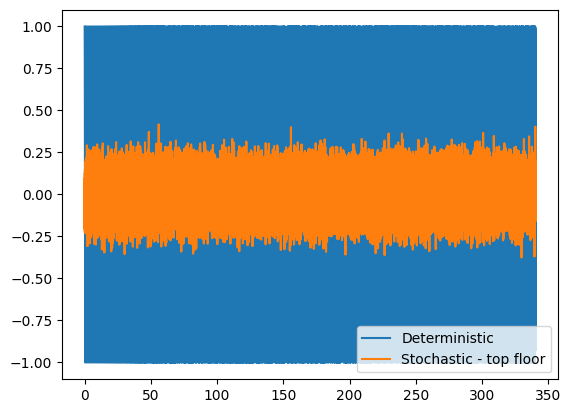

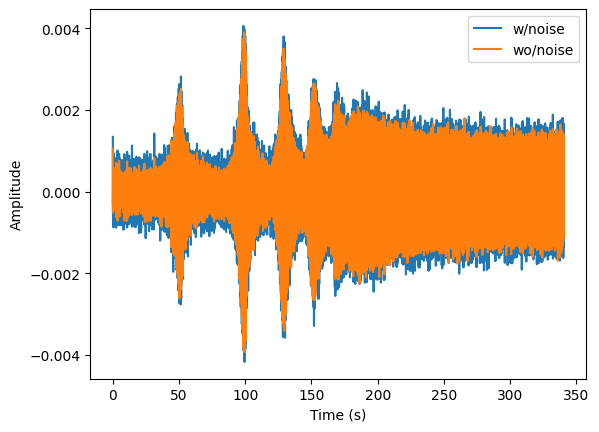

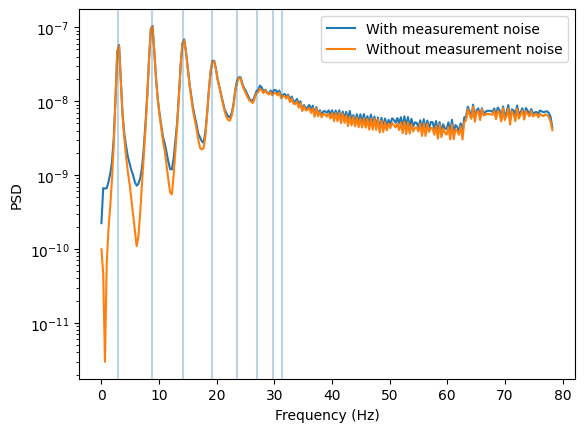

In [5]:
# generating a cos-wave that have f=1 at t=0 and fmax*2 at T. Quadratic 
# change in frequencies. Reshapet to u = [[ u ]] 
#fmax*2 are "standard"
u = scipy.signal.chirp(t, 1., T, fmax*3, method='quadratic').reshape(1, -1)


## Load matrix, f
## Generating a new load case combining the random load from the 
## random case above, and the deterministic one
F = w.copy() # Stochastic loading
F[-1] += u[0] # Deterministic loading to top floor


### From here on down it is tha same as the case above. 

# Simulate response, accelerations at each floor measured
y0, _, _ = sf.simulate(t, F)

# Add measurement noise
y = y0 + v

plt.figure("Loads")
plt.plot(t, u[0], label="Deterministic")
plt.plot(t, w[-1], label="Stochastic - top floor")
plt.legend()
plt.show()


plt.figure("Accelerations at top floor - Combined")
plt.plot(t, y[-1], label="w/noise")
plt.plot(t, y0[-1], label="wo/noise")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

plt.figure("PSD of accelerations at top floor - Combined")
teller=0
for yi in [y[-1], y0[-1],]:
    freqs, Gyy = scipy.signal.welch(yi, fs, nperseg=2**9)
    lab='With measurement noise'
    if teller==1: lab='Without measurement noise'
    teller=1
    plt.semilogy(freqs, Gyy,label=lab)
    plt.legend()
    

for n in range(1, 1+sf.n):
    plt.axvline(strid.w2f(sf.get_natural_frequency(n)), alpha=.3)
plt.ylabel('PSD')    
plt.xlabel('Frequency (Hz)')
plt.show()

## Save a new file with updated load and response

In [6]:
np.savez("results/data-combined.npz", 
         u=u, y=y, fs=fs, 
         true_frequencies=true_frequencies,
         true_damping=true_damping,
         true_modeshapes=true_modeshapes
        )
